# Query Performance Analysis by Operation Type

This notebook analyzes query performance based on the user operation type. We'll visualize how different user interactions (pan, zoom in, zoom out, etc.) affect query execution time.

In [31]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('ggplot')
# Use a more distinct color palette instead of "Set2"
sns.set_palette("tab10")  # More distinct colors
plt.rcParams['figure.figsize'] = [12, 8]

# Define a consistent color palette for operation types
OPERATION_COLORS = {
    'Initial Query': '#1f77b4',  # blue
    'Pan': '#ff7f0e',           # orange
    'Zoom In': '#2ca02c',       # green
    'Zoom Out': '#d62728',      # red
    'Pattern Detection': '#9467bd',  # purple
    'Resize': '#8c564b',        # brown
    'Measure Change': '#e377c2'  # pink
}

## Load Query Results Data

We'll load the results from the CSV files generated by the experiments.

In [32]:
def load_results(base_path="../output/timeQueries/", 
                database_type="influx", 
                table_name="intel_lab_exp", 
                run_pattern="run_*"):
    """
    Load results from multiple experiment runs into a single dataframe
    
    Parameters:
    -----------
    base_path : str
        Base path to the timeQueries directory
    database_type : str
        Type of database (influx, postgres, etc.)
    table_name : str
        Name of the database table
    run_pattern : str
        Pattern to match run folders
        
    Returns:
    --------
    pd.DataFrame: Combined results from all runs
    """
    # Create path pattern
    path_pattern = os.path.join(base_path, database_type, table_name, run_pattern, "results.csv")
    
    # Find all matching CSV files
    csv_files = glob.glob(path_pattern)
    
    if not csv_files:
        print(f"No results found matching pattern: {path_pattern}")
        return None
    
    # Load and combine all CSV files
    dfs = []
    for csv_file in csv_files:
        run_name = os.path.basename(os.path.dirname(csv_file))
        df = pd.read_csv(csv_file)
        df['run'] = run_name
        dfs.append(df)
    
    # Combine all dataframes
    combined_df = pd.concat(dfs, ignore_index=True)
    print(f"Loaded {len(csv_files)} result files with a total of {len(combined_df)} queries")
    
    # Convert date columns to datetime if they exist
    date_columns = ['from', 'to']
    for col in date_columns:
        if col in combined_df.columns:
            combined_df[col] = pd.to_datetime(combined_df[col])
            
    # Add duration column
    if 'from' in combined_df.columns and 'to' in combined_df.columns:
        combined_df['duration_sec'] = (combined_df['to'] - combined_df['from']).dt.total_seconds()
    
    return combined_df

In [33]:
# Load query results - adjust paths as needed
results = load_results(
    # base_path="../output/timeCacheQueriesM2/",
    database_type="influx",
    table_name="intel_lab_exp"
)

if results is not None:
    # Display basic information about the dataset
    display(results.head())
    
    # Check available operations
    print("\nUser Operation Types:")
    print(results['query_type'].unique())
    
    # Get number of runs
    runs = results['run'].unique()
    print(f"\nNumber of runs: {len(runs)}")
    
    # Summary statistics
    print("\nSummary Statistics by Operation Type:")
    summary = results.groupby('query_type')['Time (sec)'].agg(['count', 'mean', 'std', 'min', 'median', 'max'])
    display(summary)
    
    # Calculate per-run summary statistics
    print("\nPer-Run Statistics:")
    per_run_stats = results.groupby(['run', 'query_type'])['Time (sec)'].mean().unstack()
    display(per_run_stats)
else:
    print("No results to analyze. Run experiments first.")

Loaded 1 result files with a total of 51 queries


,dataset,query #,width,height,from,to,query_type,Time (sec),run,duration_sec
0,intel_lab_exp,0,1000,600,2004-02-28 00:58:46.000,2025-05-19 07:31:46.000,NaN,0.958154,run_0,6.697100e+08
1,intel_lab_exp,1,1000,600,2005-03-17 03:34:57.280,2024-05-01 04:57:42.656,ZI,0.740590,run_0,6.035090e+08
2,intel_lab_exp,2,1000,600,2005-06-15 06:09:40.864,2024-02-01 02:22:59.072,ZI,0.732406,run_0,5.879384e+08
3,intel_lab_exp,3,1000,600,2008-02-19 23:51:33.120,2021-05-27 08:41:06.816,ZI,0.492405,run_0,4.186398e+08
4,intel_lab_exp,4,1000,600,2004-04-28 19:21:13.379,2017-08-04 04:10:47.075,P,0.561879,run_0,4.186398e+08



User Operation Types:
[nan 'ZI' 'P' 'MC' 'PD']

Number of runs: 1

Summary Statistics by Operation Type:


,count,mean,std,min,median,max
query_type,,,,,,
MC,3,0.460207,0.151323,0.294931,0.493737,0.591954
P,20,0.340848,0.098827,0.238902,0.301513,0.564330
PD,4,0.741645,0.224306,0.491959,0.727204,1.020214
ZI,23,0.375599,0.157380,0.248154,0.292826,0.740590



Per-Run Statistics:


query_type,MC,P,PD,ZI
run,,,,
run_0,0.460207,0.340848,0.741645,0.375599


## Performance Analysis by Operation Type

Now let's visualize the performance differences between different types of user operations.

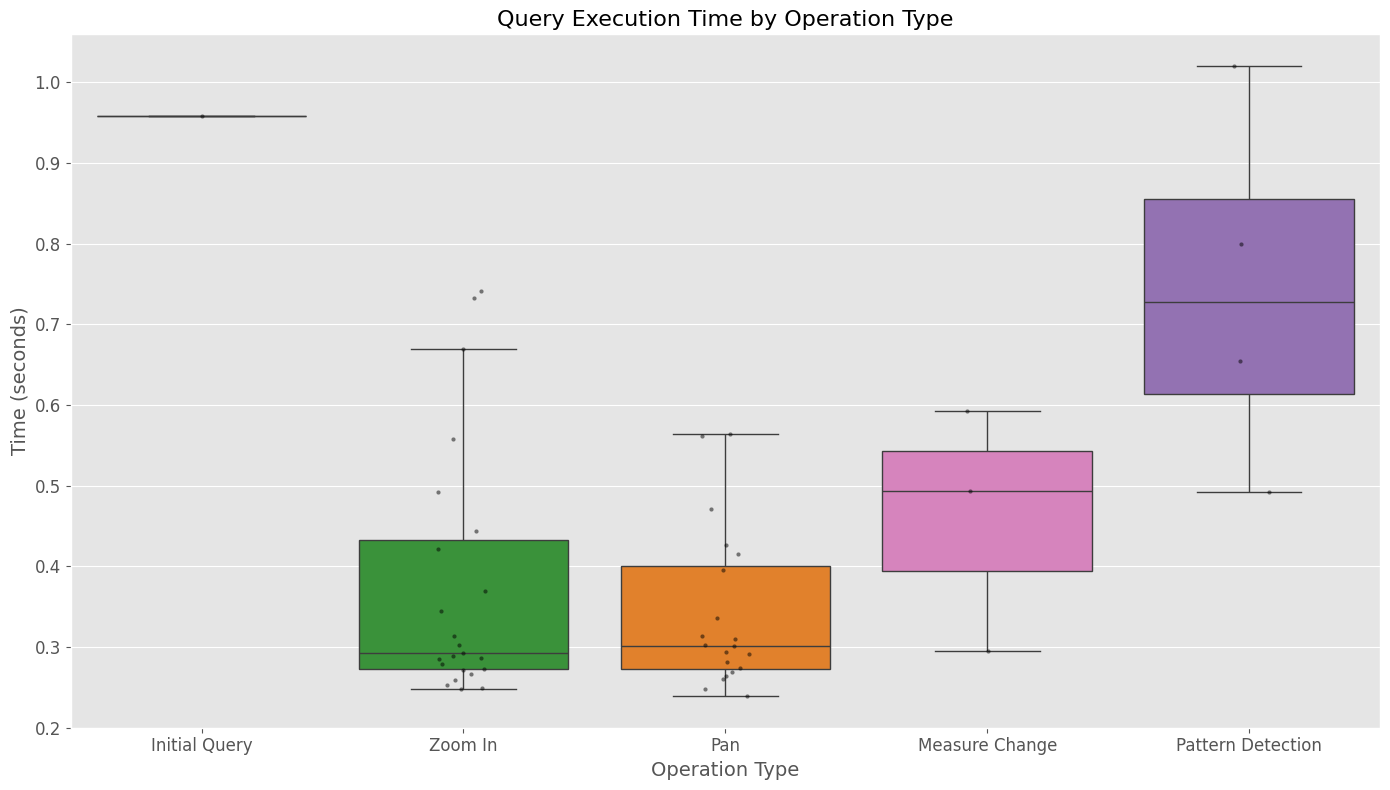

In [34]:
# Create mapping for operation type labels (for better readability)
op_type_map = {
    'P': 'Pan',
    'ZI': 'Zoom In',
    'ZO': 'Zoom Out',
    'R': 'Resize',
    'MC': 'Measure Change',
    'PD': 'Pattern Detection',
    'NaN': 'Initial Query'  # Changed from None to 'NaN'
}

if results is not None:
    # Add readable operation type
    # Handle NaN values explicitly with pandas isna function
    results['operation'] = results.apply(
        lambda row: 'Initial Query' if pd.isna(row['query_type']) else op_type_map.get(row['query_type'], row['query_type']), 
        axis=1
    )
    
    # Create a custom color palette based on the operations
    operations = results['operation'].unique()
    op_colors = [OPERATION_COLORS.get(op, 'gray') for op in operations]
    
    # Plot boxplot of query time by operation type
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='operation', y='Time (sec)', data=results, showfliers=False, palette=OPERATION_COLORS)
    sns.stripplot(x='operation', y='Time (sec)', data=results, color='black', size=3, alpha=0.5)
    plt.title('Query Execution Time by Operation Type', fontsize=16)
    plt.xlabel('Operation Type', fontsize=14)
    plt.ylabel('Time (seconds)', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

## Query Time Evolution

Let's analyze how query times evolve throughout the sequence of operations, broken down by operation type.

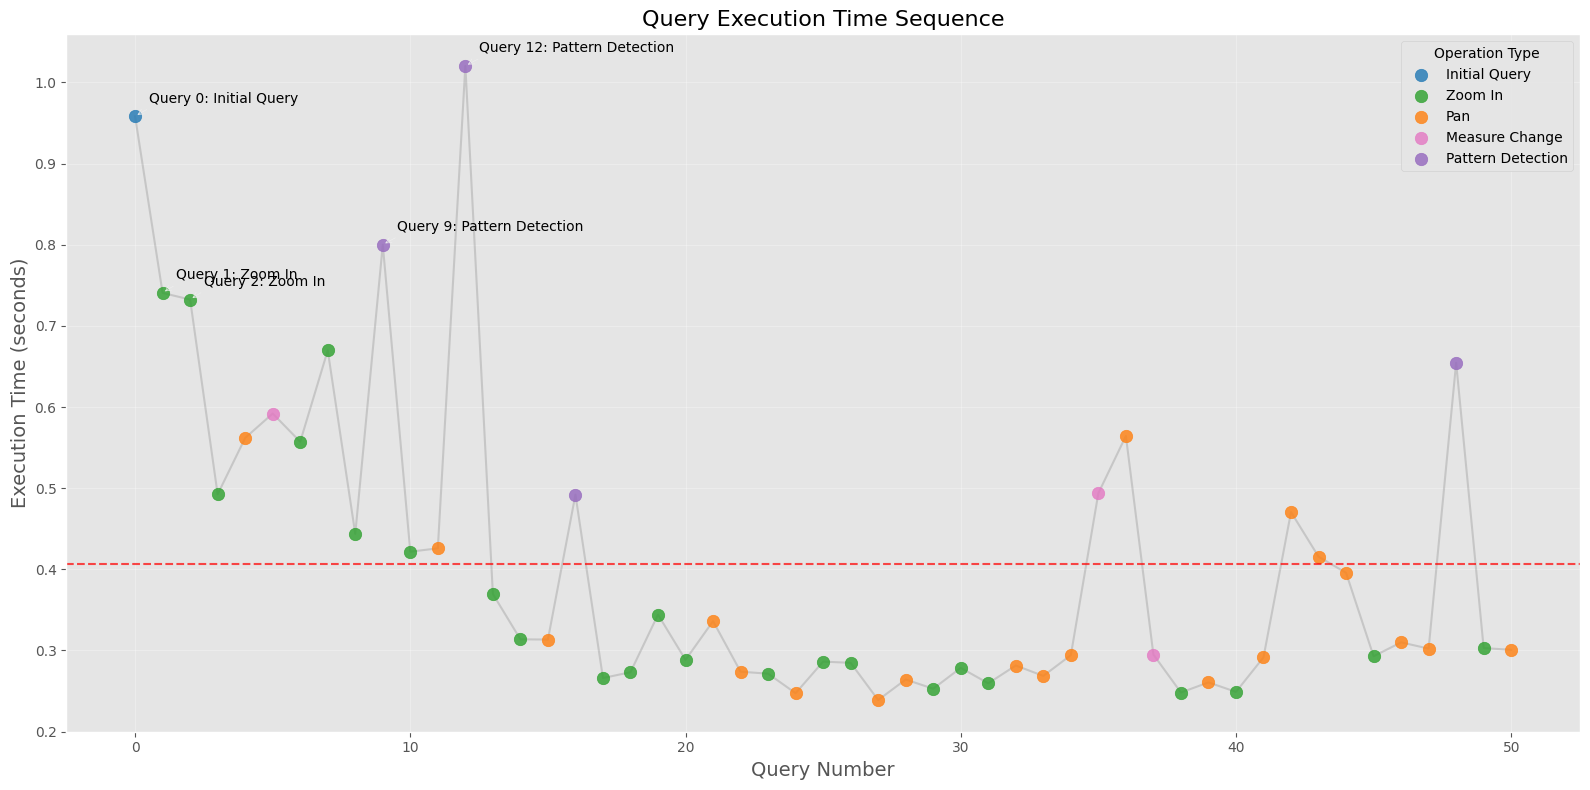

Top 5 slowest queries:


,query #,operation,Time (sec),duration_sec
12,12,Pattern Detection,1.020214,2.634820e+08
0,0,Initial Query,0.958154,6.697100e+08
9,9,Pattern Detection,0.799934,3.281857e+08
1,1,Zoom In,0.740590,6.035090e+08
2,2,Zoom In,0.732406,5.879384e+08


In [35]:
if results is not None:
    # Plot per-query execution times in sequence
    plt.figure(figsize=(16, 8))
    
    # Use the consistent color map for operation types
    operation_types = results['operation'].unique()
    
    # Plot line connecting all points to show the sequence
    plt.plot(results['query #'], results['Time (sec)'], color='gray', alpha=0.3, zorder=1)
    
    # Plot scatter with points colored by operation type
    for op_type in operation_types:
        subset = results[results['operation'] == op_type]
        plt.scatter(subset['query #'], subset['Time (sec)'], 
                   label=op_type, color=OPERATION_COLORS.get(op_type, 'gray'), s=80, alpha=0.8, zorder=2)
    
    # Highlight slow queries (outliers)
    threshold = results['Time (sec)'].mean() + 1.5 * results['Time (sec)'].std()
    slow_queries = results[results['Time (sec)'] > threshold]
    
    # Annotate slow queries
    for i, row in slow_queries.iterrows():
        plt.annotate(f"Query {int(row['query #'])}: {row['operation']}", 
                    xy=(row['query #'], row['Time (sec)']),
                    xytext=(10, 10), textcoords='offset points',
                    arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2'))
    
    plt.title('Query Execution Time Sequence', fontsize=16)
    plt.xlabel('Query Number', fontsize=14)
    plt.ylabel('Execution Time (seconds)', fontsize=14)
    plt.legend(title='Operation Type')
    plt.grid(True, alpha=0.3)
    
    # Add horizontal line for average execution time
    plt.axhline(y=results['Time (sec)'].mean(), color='red', linestyle='--', 
               alpha=0.7, label=f'Mean: {results["Time (sec)"].mean():.3f}s')
    
    plt.tight_layout()
    plt.show()
    
    # Show detailed statistics for the top 5 slowest queries
    print("Top 5 slowest queries:")
    slowest_queries = results.nlargest(5, 'Time (sec)')
    display(slowest_queries[['query #', 'operation', 'Time (sec)', 'duration_sec']])

## Per-Query Time Analysis

Now let's examine the execution time for each individual query in more detail, with a focus on identifying patterns and outliers.

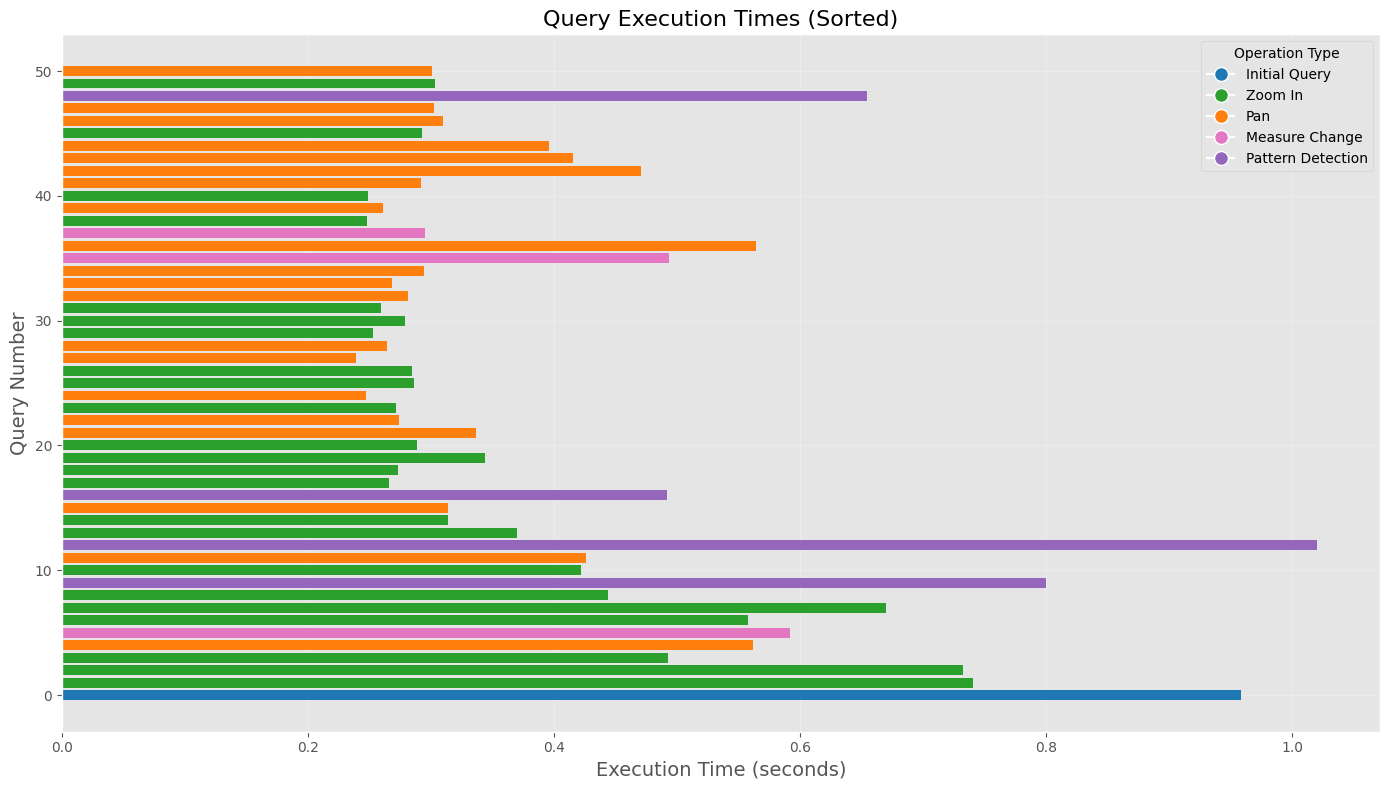

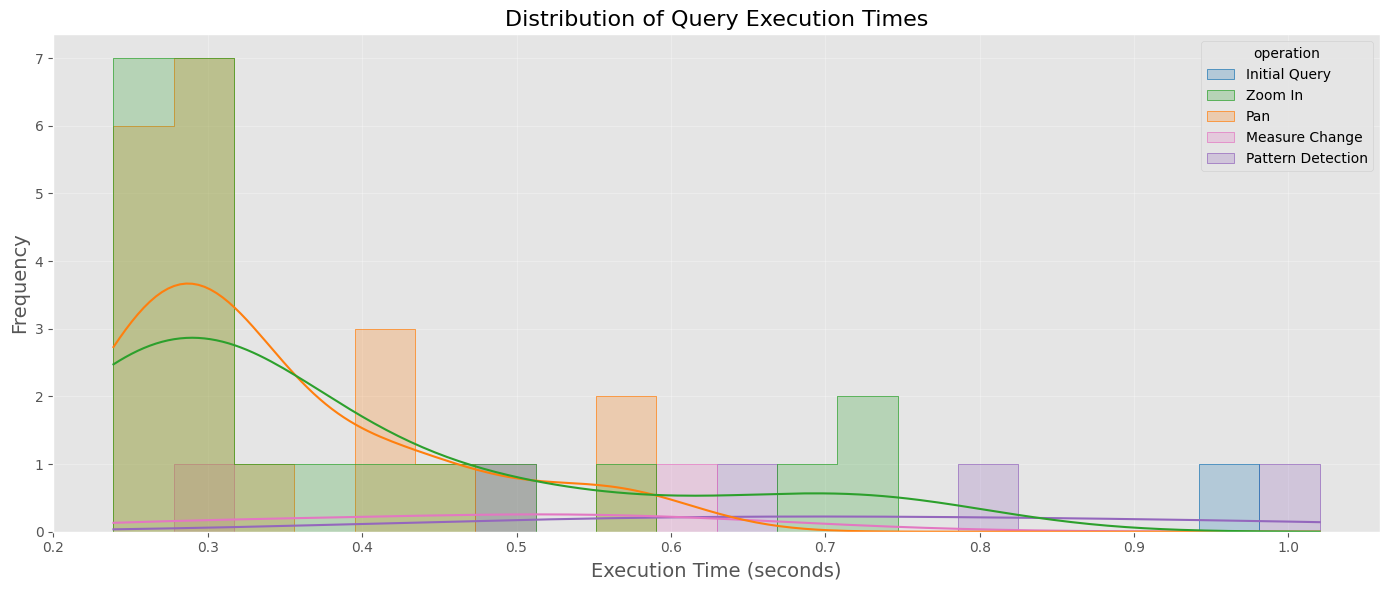

In [36]:
if results is not None:
    # Create a more detailed table view of all queries
    # Sort by execution time to see the slowest and fastest queries
    sorted_results = results.sort_values('Time (sec)', ascending=False).reset_index(drop=True)
    
    # Add percentile column to show how each query compares to others
    sorted_results['percentile'] = sorted_results['Time (sec)'].rank(pct=True) * 100
    
    # Display the results
    plt.figure(figsize=(14, 8))
    
    # Create a horizontal bar chart of query times with consistent colors
    bar_colors = [OPERATION_COLORS.get(op, 'gray') for op in sorted_results['operation']]
    bars = plt.barh(sorted_results['query #'], sorted_results['Time (sec)'], color=bar_colors)
    
    plt.title('Query Execution Times (Sorted)', fontsize=16)
    plt.xlabel('Execution Time (seconds)', fontsize=14)
    plt.ylabel('Query Number', fontsize=14)
    
    # Add operation type as color legend
    from matplotlib.lines import Line2D
    legend_elements = [Line2D([0], [0], marker='o', color='w', 
                             markerfacecolor=OPERATION_COLORS.get(op, 'gray'), markersize=10, label=op)
                      for op in operation_types]
    plt.legend(handles=legend_elements, title='Operation Type', loc='upper right')
    
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Show the distribution of execution times with a histogram
    plt.figure(figsize=(14, 6))
    sns.histplot(data=results, x='Time (sec)', hue='operation', bins=20, kde=True, element='step',
                palette=OPERATION_COLORS)
    plt.title('Distribution of Query Execution Times', fontsize=16)
    plt.xlabel('Execution Time (seconds)', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## Average Performance by Operation Type

If we have multiple runs, it's important to see the average performance for each operation type across all runs.

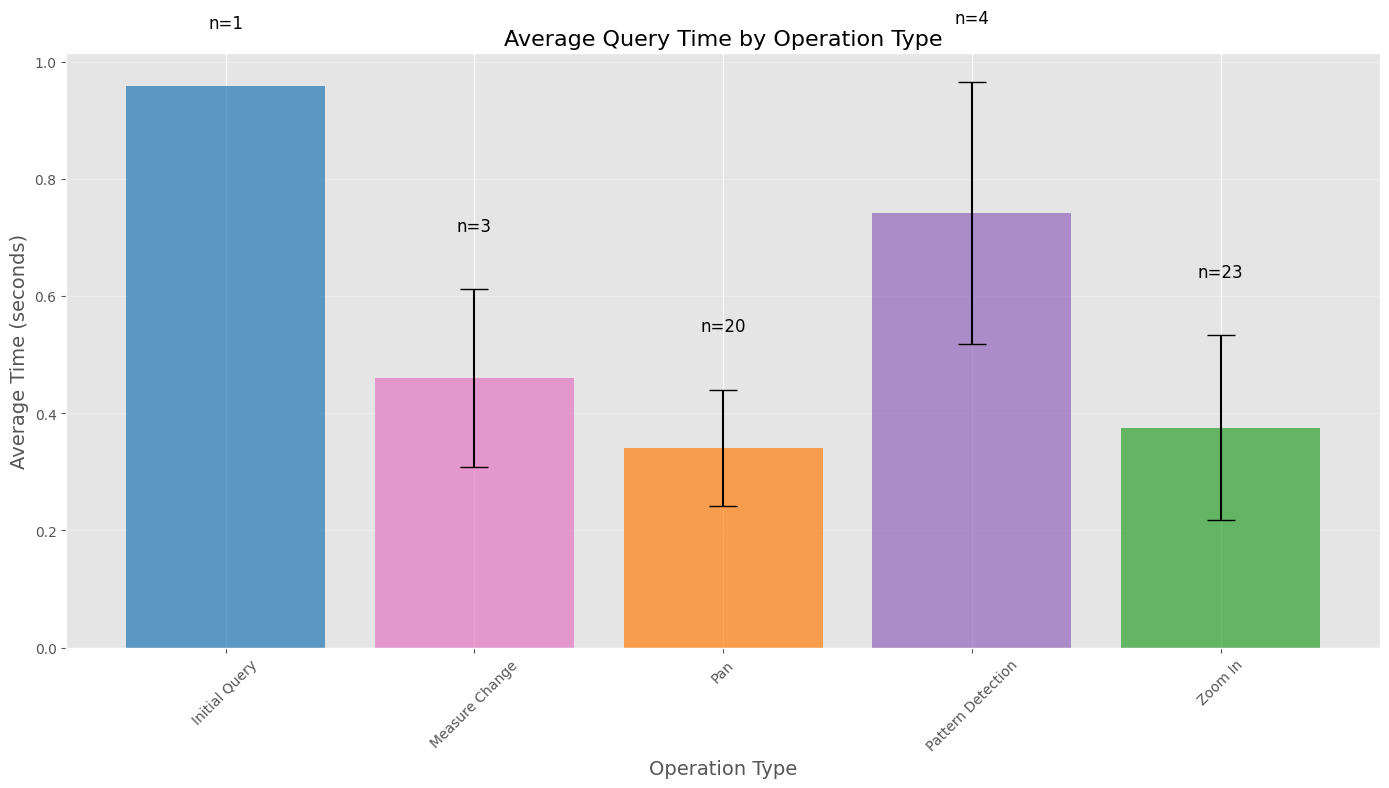

In [37]:
if results is not None:
    # Get average performance by operation type
    avg_by_op_type = results.groupby(['operation'])['Time (sec)'].agg(['mean', 'std', 'count']).reset_index()
    
    # Create a more informative plot with error bars
    plt.figure(figsize=(14, 8))
    
    # Get colors for each operation using the consistent color map
    op_colors = [OPERATION_COLORS.get(op, 'gray') for op in avg_by_op_type['operation']]
    
    # Add bars with error
    bars = plt.bar(avg_by_op_type['operation'], avg_by_op_type['mean'], 
            yerr=avg_by_op_type['std'], capsize=10, alpha=0.7, color=op_colors)
    
    # Add count annotations on top of bars
    for i, (op, mean, std, count) in enumerate(avg_by_op_type.itertuples(index=False)):
        plt.text(i, mean + (std if pd.notna(std) else 0) + 0.1, f"n={count}", ha='center', fontsize=12)
    
    plt.title('Average Query Time by Operation Type', fontsize=16)
    plt.xlabel('Operation Type', fontsize=14)
    plt.ylabel('Average Time (seconds)', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # If we have multiple runs, show inter-run variability
    if len(runs) > 1:
        plt.figure(figsize=(14, 8))
        # Group by run and operation type
        run_op_stats = results.groupby(['run', 'operation'])['Time (sec)'].mean().unstack()
        
        # Plot with the consistent color palette
        ax = run_op_stats.plot(kind='bar', figsize=(14, 8), color=[OPERATION_COLORS.get(op, 'gray') for op in run_op_stats.columns])
        
        plt.title('Query Time by Operation Type Across Runs', fontsize=16)
        plt.xlabel('Run', fontsize=14)
        plt.ylabel('Average Time (seconds)', fontsize=14)
        plt.legend(title='Operation Type')
        plt.grid(axis='y', alpha=0.3)
        plt.tight_layout()
        plt.show()

## Operation Type Frequency Analysis

Let's look at the distribution of different operation types in our query sequence.

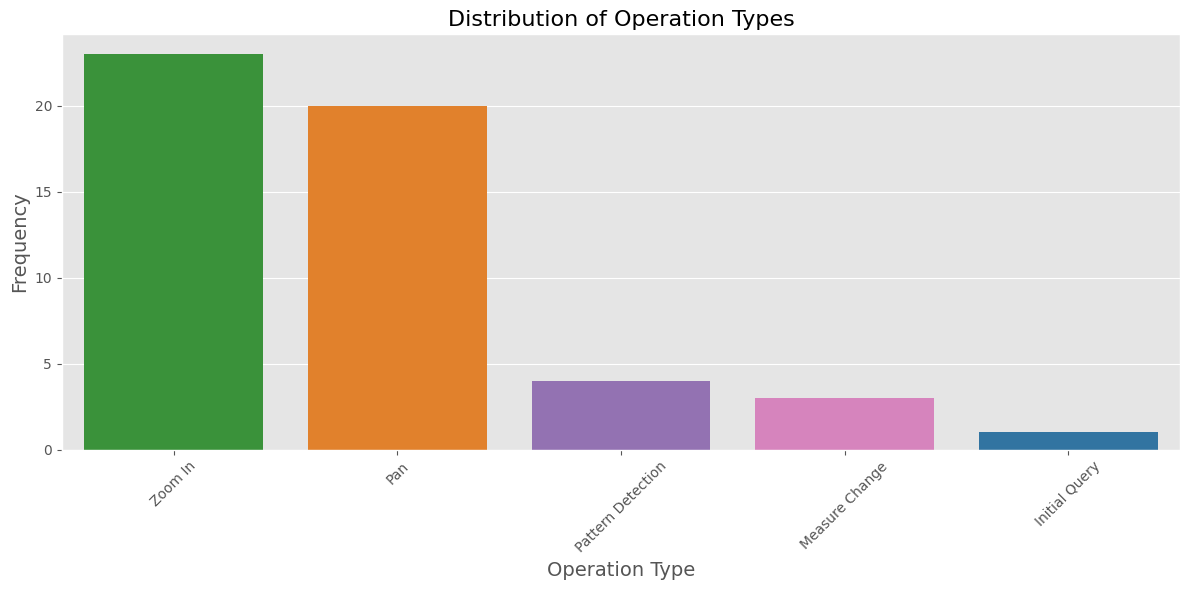

In [38]:
if results is not None:
    # Count frequency of each operation type
    op_counts = results['operation'].value_counts().reset_index()
    op_counts.columns = ['Operation', 'Count']
    
    # Plot operation type distribution with consistent colors
    plt.figure(figsize=(12, 6))
    
    # Get colors for each operation using the consistent color map
    op_colors = [OPERATION_COLORS.get(op, 'gray') for op in op_counts['Operation']]
    
    # Create bar plot with custom colors
    sns.barplot(x='Operation', y='Count', data=op_counts, palette=OPERATION_COLORS)
    
    plt.title('Distribution of Operation Types', fontsize=16)
    plt.xlabel('Operation Type', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

## Statistical Analysis of Operation Types

Let's perform statistical analysis to determine if there are significant differences in query times between operation types.

In [39]:
if results is not None:
    from scipy import stats
    
    # Prepare for ANOVA test
    operations = results['operation'].unique()
    if len(operations) >= 2:
        # If we have multiple operation types, perform ANOVA
        operation_groups = [results[results['operation'] == op]['Time (sec)'] for op in operations]
        
        # Remove empty groups
        operation_groups = [group for group in operation_groups if len(group) > 0]
        
        if len(operation_groups) >= 2:
            # Perform one-way ANOVA
            f_stat, p_value = stats.f_oneway(*operation_groups)
            
            print("One-way ANOVA Test Results:")
            print(f"F-statistic: {f_stat:.4f}")
            print(f"p-value: {p_value:.4f}")
            
            if p_value < 0.05:
                print("There is a statistically significant difference in query times between operation types")
            else:
                print("No statistically significant difference found between operation types")
        else:
            print("Not enough operation groups with data for statistical analysis")
    else:
        print("Need at least 2 operation types to perform statistical analysis")

One-way ANOVA Test Results:
F-statistic: 10.7955
p-value: 0.0000
There is a statistically significant difference in query times between operation types


## Statistical Comparison of Performance Across Runs

Let's analyze whether there are significant differences in query performance across multiple runs.

In [40]:
if results is not None and len(runs) > 1:
    from scipy import stats
    
    # Perform statistical tests for differences between runs
    print("Statistical comparison of runs:")
    
    # Group mean execution times by run
    run_means = results.groupby('run')['Time (sec)'].mean()
    display(run_means)
    
    # Calculate coefficient of variation to assess consistency across runs
    cv = run_means.std() / run_means.mean()
    print(f"Coefficient of variation across runs: {cv:.4f}")
    print(f"Interpretation: {'Low variation (<0.1)' if cv < 0.1 else 'Moderate variation (0.1-0.3)' if cv < 0.3 else 'High variation (>0.3)'}")
    
    # If we have more than 2 runs, perform one-way ANOVA
    if len(runs) > 2:
        run_groups = [results[results['run'] == run]['Time (sec)'] for run in runs]
        f_stat, p_value = stats.f_oneway(*run_groups)
        
        print("\nOne-way ANOVA for differences between runs:")
        print(f"F-statistic: {f_stat:.4f}")
        print(f"p-value: {p_value:.4f}")
        
        if p_value < 0.05:
            print("There are statistically significant differences between runs")
        else:
            print("No statistically significant differences between runs")
    # If we have exactly 2 runs, use t-test instead
    elif len(runs) == 2:
        t_stat, p_value = stats.ttest_ind(
            results[results['run'] == runs[0]]['Time (sec)'],
            results[results['run'] == runs[1]]['Time (sec)']
        )
        
        
        print("\nIndependent t-test for differences between runs:")
        print(f"t-statistic: {t_stat:.4f}")
        print(f"p-value: {p_value:.4f}")
        
        if p_value < 0.05:
            print("There is a statistically significant difference between the two runs")
        else:
            print("No statistically significant difference between the two runs")

## Performance Consistency Analysis

Let's examine how consistent the performance is for each operation type across multiple runs.

In [41]:
if results is not None and len(runs) > 1:
    # Calculate coefficient of variation for each operation type across runs
    cv_by_op = results.groupby(['run', 'operation'])['Time (sec)'].mean().reset_index()
    cv_by_op = cv_by_op.groupby('operation').agg({
        'Time (sec)': ['mean', 'std', lambda x: np.std(x)/np.mean(x) if np.mean(x) > 0 else 0]
    }).reset_index()
    
    # Rename columns for clarity
    cv_by_op.columns = ['Operation', 'Mean Time', 'Std Dev', 'CV']
    
    # Sort by coefficient of variation (descending)
    cv_by_op = cv_by_op.sort_values('CV', ascending=False)
    
    # Display the table
    print("Operation Performance Consistency (Coefficient of Variation):")
    display(cv_by_op)
    
    # Get colors for each operation using the consistent color map
    op_colors = [OPERATION_COLORS.get(op, 'gray') for op in cv_by_op['Operation']]
    
    # Visualize with a horizontal bar chart
    plt.figure(figsize=(12, 8))
    plt.barh(cv_by_op['Operation'], cv_by_op['CV'], color=op_colors)
    plt.xlabel('Coefficient of Variation (lower is more consistent)')
    plt.ylabel('Operation Type')
    plt.title('Performance Consistency by Operation Type Across Runs')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()

## Conclusion

This analysis visualizes how different user operations affect query performance. Key findings include:

1. The performance differences between various operation types
2. How query execution time evolves throughout a sequence of operations
3. The impact of viewport size on query performance
4. The relationship between query time window duration and execution time
5. The consistency of performance across multiple experimental runs

These insights can help optimize the caching strategy for different operation types and improve overall user experience.